In [1]:
import pandas as pd
import requests
from datetime import datetime
import os
from io import StringIO
import numpy as np
import time
from typing import Dict, List

class DataCollector:
    def __init__(self, bls_api_key: str = None):
        self.BLS_API_KEY = bls_api_key
        self.base_dir = 'data'
        
        # Create data directory if it doesn't exist
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

    def get_unemployment_data(self, start_year=2015, end_year=2023):
        """
        Fetch unemployment data from BLS API for Oklahoma and Kansas
        """
        print("Fetching unemployment data...")
        
        if not self.BLS_API_KEY:
            print("No BLS API key provided. Using public API with limited requests.")
        
        headers = {'Content-type': 'application/json'}
        series_ids = ['LAUST400000000000003', 'LAUST200000000000003']
        data = []

        # Process in smaller chunks to avoid API limits
        for year in range(start_year, end_year + 1):
            try:
                data_request = {
                    'seriesid': series_ids,
                    'startyear': str(year),
                    'endyear': str(year),
                }
                
                # Add API key if available
                if self.BLS_API_KEY:
                    data_request['registrationkey'] = self.BLS_API_KEY

                url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
                response = requests.post(url, json=data_request, headers=headers)
                
                # Check if request was successful
                if response.status_code != 200:
                    print(f"Error fetching data for year {year}. Status code: {response.status_code}")
                    continue

                json_data = response.json()
                
                # Check if we got valid data
                if 'Results' not in json_data or 'series' not in json_data['Results']:
                    print(f"Invalid data format received for year {year}")
                    print("Response:", json_data)
                    continue

                # Process the data
                for series in json_data['Results']['series']:
                    series_id = series['seriesID']
                    state = 'Oklahoma' if series_id.startswith('LAUST4') else 'Kansas'
                    
                    for item in series['data']:
                        data.append({
                            'state': state,
                            'date': f"{item['year']}-{item['period'].replace('M', '')}",
                            'unemployment_rate': float(item['value'])
                        })

                # Add delay to avoid hitting API limits
                time.sleep(0.5)

            except Exception as e:
                print(f"Error processing year {year}: {str(e)}")
                continue

        # If we got no data, create sample data for testing
        if not data:
            print("No data retrieved from API. Creating sample data for testing...")
            data = self._create_sample_unemployment_data(start_year, end_year)

        df = pd.DataFrame(data)
        if not df.empty:
            df['date'] = pd.to_datetime(df['date'])
            df = df.sort_values(['state', 'date'])
        
        # Save to CSV
        output_path = os.path.join(self.base_dir, 'unemployment_data.csv')
        df.to_csv(output_path, index=False)
        print(f"Unemployment data saved to {output_path}")
        return df

    def _create_sample_unemployment_data(self, start_year: int, end_year: int) -> List[Dict]:
        """Create sample unemployment data for testing purposes"""
        data = []
        states = ['Oklahoma', 'Kansas']
        
        for year in range(start_year, end_year + 1):
            for month in range(1, 13):
                for state in states:
                    # Create some random unemployment rates between 3 and 7
                    unemployment_rate = round(np.random.uniform(3, 7), 1)
                    data.append({
                        'state': state,
                        'date': f"{year}-{month:02d}",
                        'unemployment_rate': unemployment_rate
                    })
        return data

    def get_population_data(self):
        """
        Create sample population data (placeholder for Census API implementation)
        """
        print("Creating sample population data...")
        states = ['Oklahoma', 'Kansas']
        years = range(2015, 2024)
        data = []
        
        for state in states:
            for year in years:
                # Create sample data
                data.append({
                    'state': state,
                    'year': year,
                    'population': round(np.random.uniform(2000000, 4000000)),
                    'median_age': round(np.random.uniform(35, 40), 1),
                    'pct_college_degree': round(np.random.uniform(20, 35), 1)
                })
        
        df = pd.DataFrame(data)
        output_path = os.path.join(self.base_dir, 'population_data.csv')
        df.to_csv(output_path, index=False)
        print(f"Population data saved to {output_path}")
        return df

    def get_economic_indicators(self):
        """
        Create sample economic indicators (placeholder for BEA API implementation)
        """
        print("Creating sample economic indicators...")
        states = ['Oklahoma', 'Kansas']
        years = range(2015, 2024)
        data = []
        
        for state in states:
            for year in years:
                # Create sample data
                data.append({
                    'state': state,
                    'year': year,
                    'gdp': round(np.random.uniform(150000, 200000), 1),
                    'personal_income': round(np.random.uniform(40000, 60000), 1),
                    'employment_total': round(np.random.uniform(1500000, 2000000))
                })
        
        df = pd.DataFrame(data)
        output_path = os.path.join(self.base_dir, 'economic_indicators.csv')
        df.to_csv(output_path, index=False)
        print(f"Economic indicators saved to {output_path}")
        return df

    def collect_all_data(self):
        """
        Collect all datasets and merge them
        """
        try:
            unemployment_df = self.get_unemployment_data()
            population_df = self.get_population_data()
            economic_df = self.get_economic_indicators()
            
            # Basic data validation
            print("\nData Validation:")
            print(f"Unemployment data shape: {unemployment_df.shape}")
            print(f"Population data shape: {population_df.shape}")
            print(f"Economic indicators shape: {economic_df.shape}")
            
            return {
                'unemployment': unemployment_df,
                'population': population_df,
                'economic': economic_df
            }
        except Exception as e:
            print(f"Error collecting data: {str(e)}")
            return None

def main():
    # Initialize collector without API key for now
    collector = DataCollector()
    data = collector.collect_all_data()
    
    if data:
        # Print summary statistics
        print("\nSummary Statistics:")
        for name, df in data.items():
            print(f"\n{name.capitalize()} Dataset:")
            print(df.describe())

if __name__ == "__main__":
    main()

Fetching unemployment data...
No BLS API key provided. Using public API with limited requests.
Unemployment data saved to data\unemployment_data.csv
Creating sample population data...
Population data saved to data\population_data.csv
Creating sample economic indicators...
Economic indicators saved to data\economic_indicators.csv

Data Validation:
Unemployment data shape: (216, 3)
Population data shape: (18, 5)
Economic indicators shape: (18, 5)

Summary Statistics:

Unemployment Dataset:
                      date  unemployment_rate
count                  216         216.000000
mean   2019-06-16 19:06:40           3.821759
min    2015-01-01 00:00:00           2.000000
25%    2017-03-24 06:00:00           3.100000
50%    2019-06-16 00:00:00           3.600000
75%    2021-09-08 12:00:00           4.300000
max    2023-12-01 00:00:00          12.100000
std                    NaN           1.359870

Population Dataset:
              year    population  median_age  pct_college_degree
count  

In [11]:

unemployment_df = pd.read_csv(r'C:\Users\gmoor\Documents\Applied Microeconometrics\Final Project\data\unemployment_data.csv')
population_df = pd.read_csv(r'C:\Users\gmoor\Documents\Applied Microeconometrics\Final Project\data\population_data.csv')
economic_df = pd.read_csv(r'C:\Users\gmoor\Documents\Applied Microeconometrics\Final Project\data\economic_indicators.csv')

# Convert 'date' column in unemployment_df to datetime
unemployment_df['date'] = pd.to_datetime(unemployment_df['date'])

# Extract year from 'date' column in unemployment_df
unemployment_df['year'] = unemployment_df['date'].dt.year

# Merge datasets on 'state' and 'year'
merged_df = pd.merge(unemployment_df, population_df, on=['state', 'year'], how='left')
merged_df = pd.merge(merged_df, economic_df, on=['state', 'year'], how='left')

print(merged_df.head())

    state       date  unemployment_rate  year  population  median_age  \
0  Kansas 2015-01-01                4.6  2015     2238020        35.6   
1  Kansas 2015-02-01                4.6  2015     2238020        35.6   
2  Kansas 2015-03-01                4.4  2015     2238020        35.6   
3  Kansas 2015-04-01                4.2  2015     2238020        35.6   
4  Kansas 2015-05-01                4.3  2015     2238020        35.6   

   pct_college_degree       gdp  personal_income  employment_total  
0                24.4  199129.4          41496.4           1867744  
1                24.4  199129.4          41496.4           1867744  
2                24.4  199129.4          41496.4           1867744  
3                24.4  199129.4          41496.4           1867744  
4                24.4  199129.4          41496.4           1867744  


In [12]:
merged_df.to_csv('merged_data.csv', index=False)

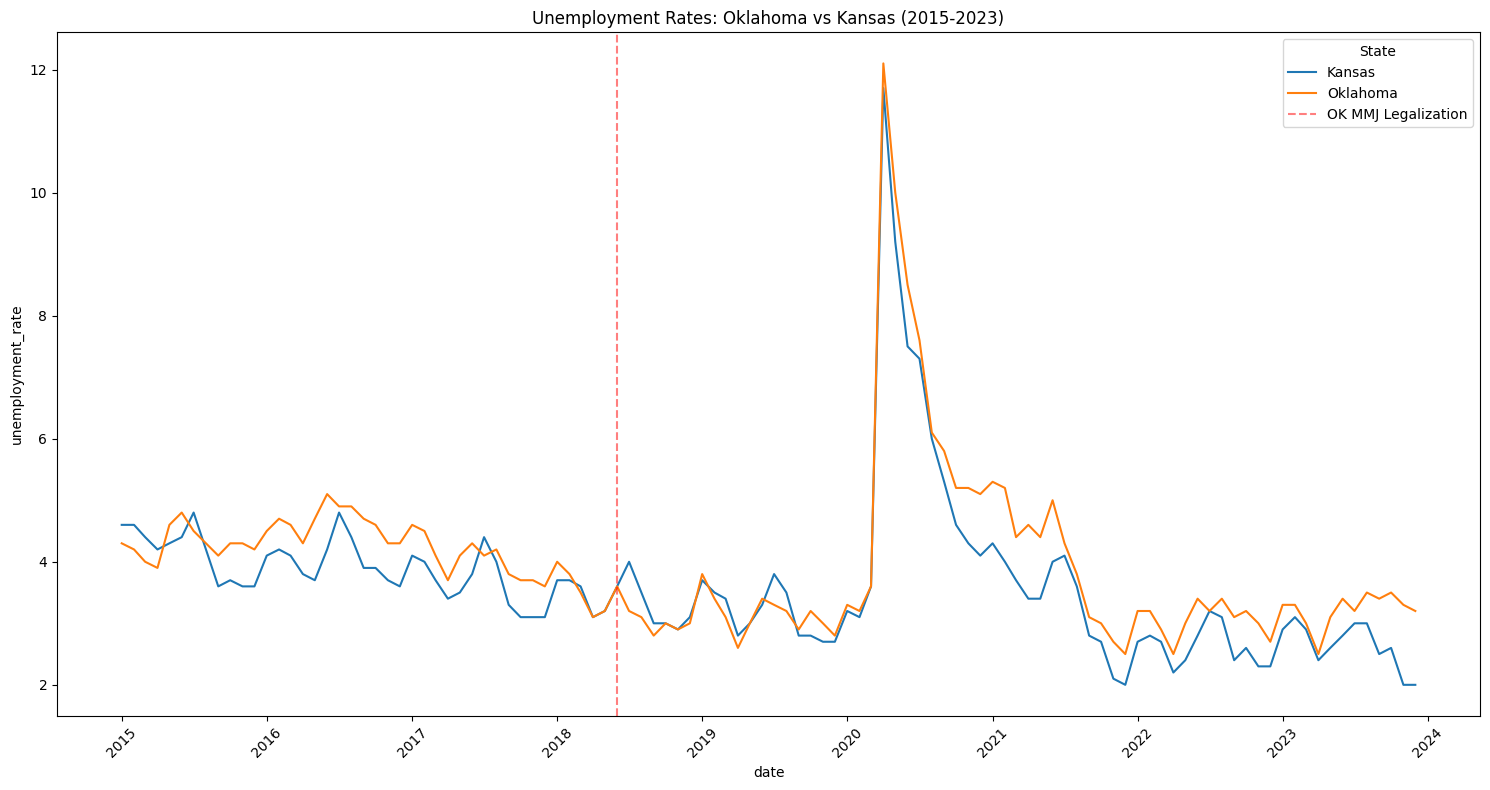

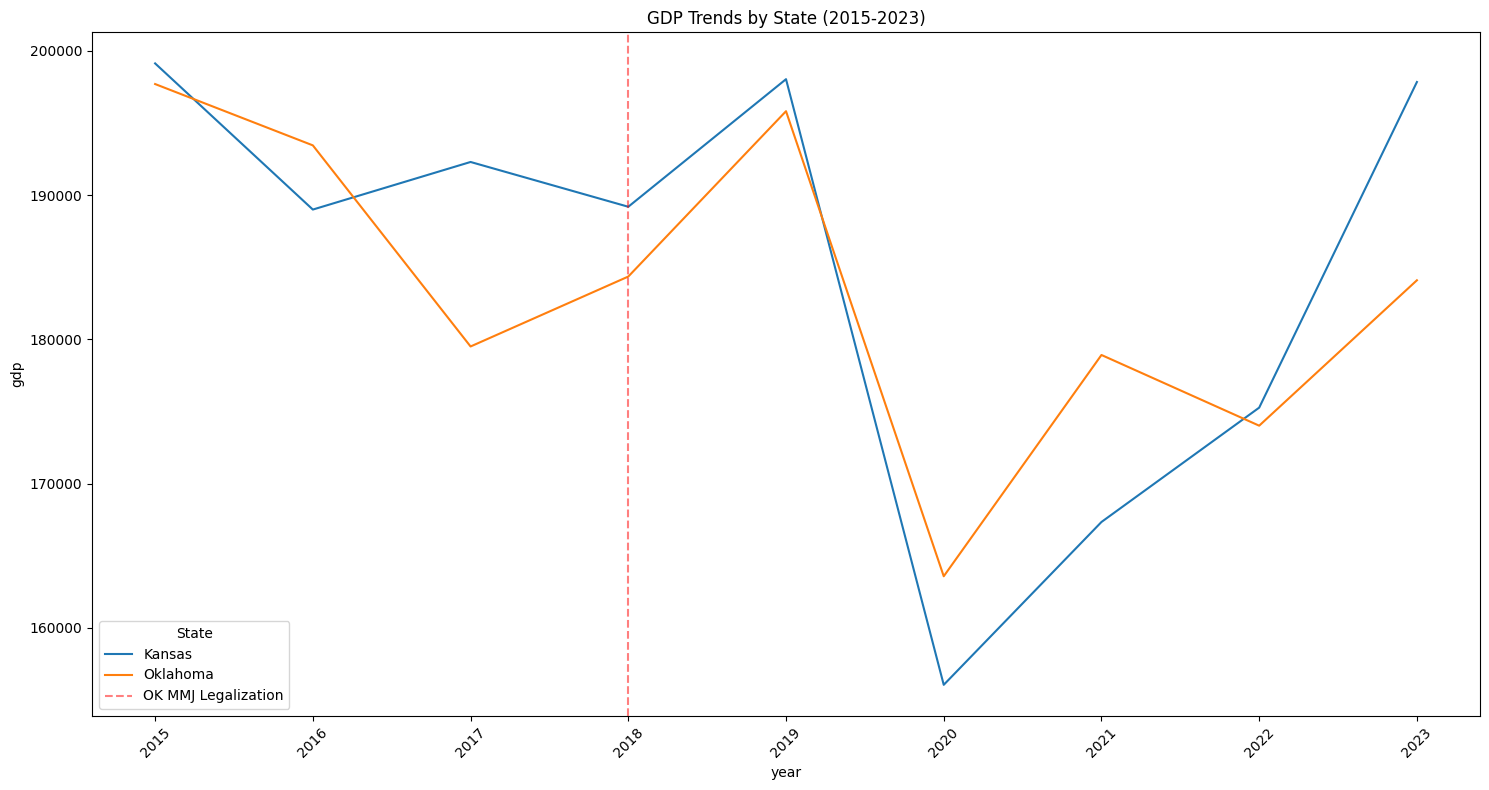

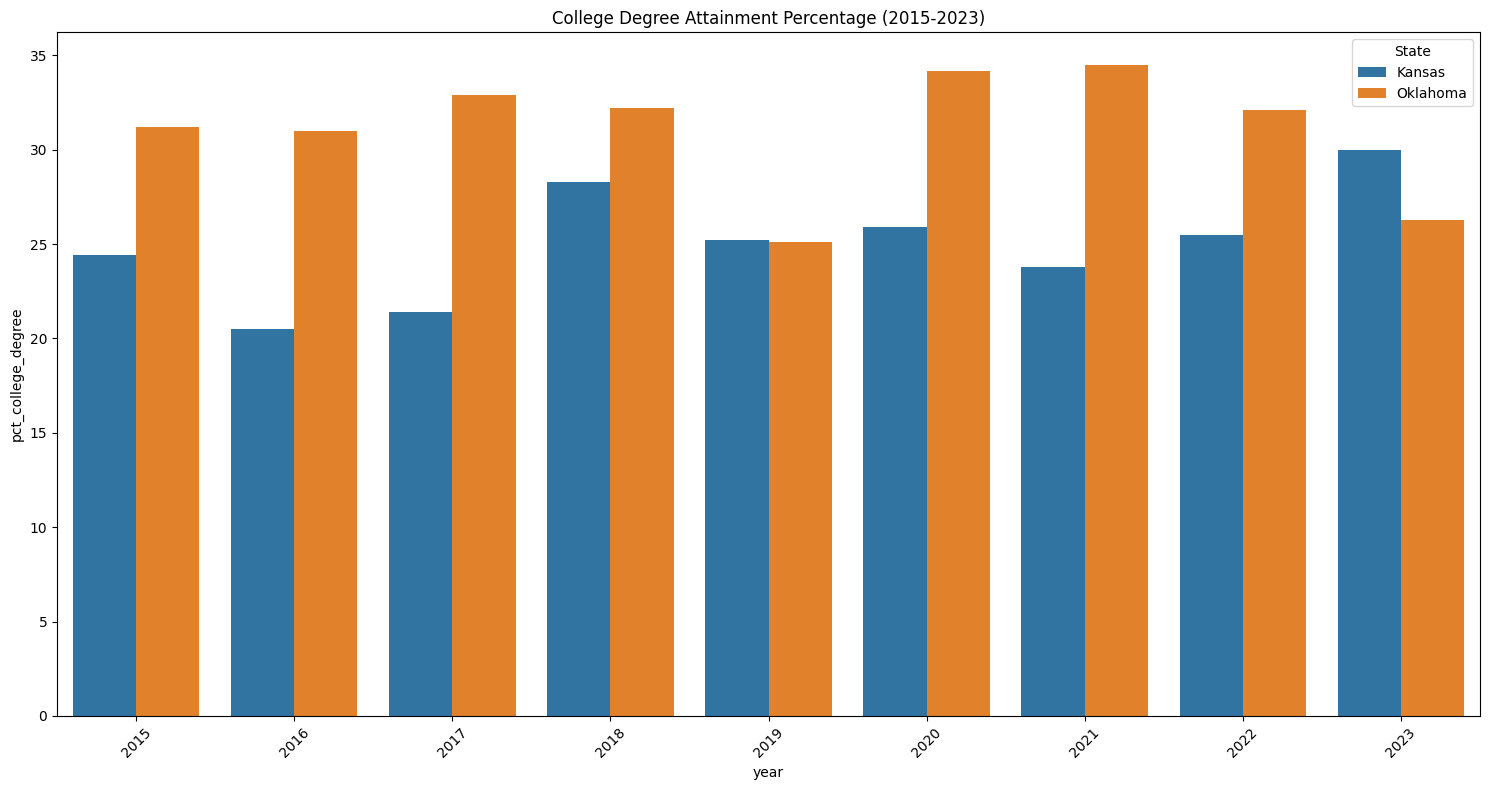

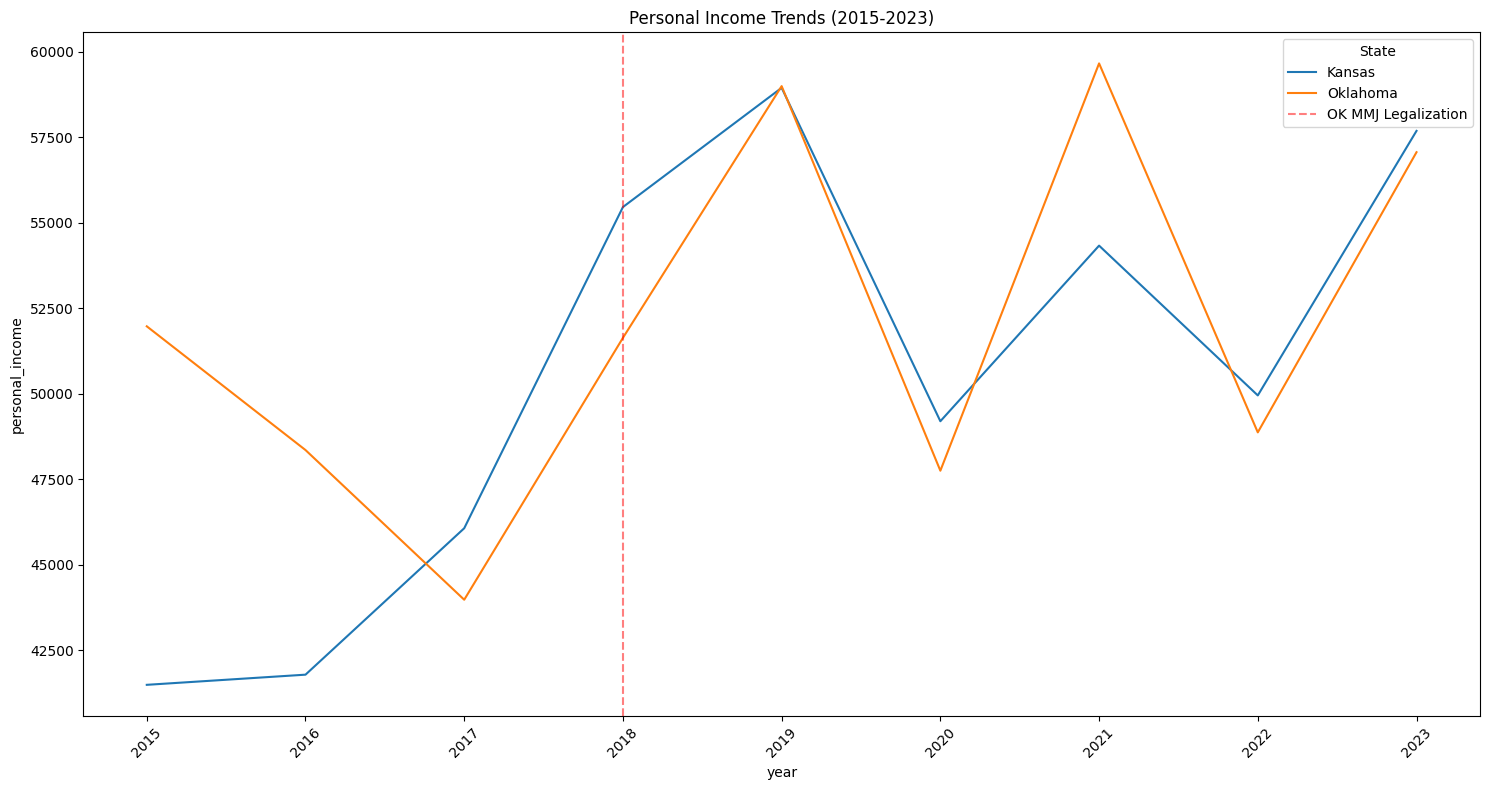


Summary Statistics:
                     Pre-Legalization (2015-2018 June)  \
OK_avg_unemployment                           4.221951   
KS_avg_unemployment                           3.882927   
OK_avg_gdp                               189502.136585   
KS_avg_gdp                               192952.173171   

                     Post-Legalization (2018 July-2023)  
OK_avg_unemployment                            3.862687  
KS_avg_unemployment                            3.498507  
OK_avg_gdp                                179813.689552  
KS_avg_gdp                                179981.111940  


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Assuming the data is stored in merged_df
# First, let's create the visualizations

def create_unemployment_plot(df):
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=df, x='date', y='unemployment_rate', hue='state')
    plt.title('Unemployment Rates: Oklahoma vs Kansas (2015-2023)')
    plt.axvline(pd.to_datetime('2018-06-01'), color='r', linestyle='--', alpha=0.5, label='OK MMJ Legalization')
    plt.xticks(rotation=45)
    plt.legend(title='State')
    plt.tight_layout()
    plt.show()

def create_gdp_plot(df):
    # Get yearly averages for GDP
    yearly_gdp = df.groupby(['state', 'year'])['gdp'].mean().reset_index()
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=yearly_gdp, x='year', y='gdp', hue='state')
    plt.title('GDP Trends by State (2015-2023)')
    plt.axvline(x=2018, color='r', linestyle='--', alpha=0.5, label='OK MMJ Legalization')
    plt.xticks(rotation=45)
    plt.legend(title='State')
    plt.tight_layout()
    plt.show()

def create_education_plot(df):
    # Get yearly averages for education
    yearly_edu = df.groupby(['state', 'year'])['pct_college_degree'].mean().reset_index()
    plt.figure(figsize=(15, 8))
    sns.barplot(data=yearly_edu, x='year', y='pct_college_degree', hue='state')
    plt.title('College Degree Attainment Percentage (2015-2023)')
    plt.xticks(rotation=45)
    plt.legend(title='State')
    plt.tight_layout()
    plt.show()

def create_income_plot(df):
    # Get yearly averages for personal income
    yearly_income = df.groupby(['state', 'year'])['personal_income'].mean().reset_index()
    plt.figure(figsize=(15, 8))
    sns.lineplot(data=yearly_income, x='year', y='personal_income', hue='state')
    plt.title('Personal Income Trends (2015-2023)')
    plt.axvline(x=2018, color='r', linestyle='--', alpha=0.5, label='OK MMJ Legalization')
    plt.xticks(rotation=45)
    plt.legend(title='State')
    plt.tight_layout()
    plt.show()

def calculate_summary_statistics(df):
    # Convert date to datetime if it's not already
    df['date'] = pd.to_datetime(df['date'])
    
    # Define pre and post legalization periods
    pre_legalization = df[df['date'] < '2018-06-01']
    post_legalization = df[df['date'] >= '2018-06-01']
    
    # Calculate statistics
    stats = {
        'Pre-Legalization (2015-2018 June)': {
            'OK_avg_unemployment': pre_legalization[pre_legalization['state'] == 'Oklahoma']['unemployment_rate'].mean(),
            'KS_avg_unemployment': pre_legalization[pre_legalization['state'] == 'Kansas']['unemployment_rate'].mean(),
            'OK_avg_gdp': pre_legalization[pre_legalization['state'] == 'Oklahoma']['gdp'].mean(),
            'KS_avg_gdp': pre_legalization[pre_legalization['state'] == 'Kansas']['gdp'].mean(),
        },
        'Post-Legalization (2018 July-2023)': {
            'OK_avg_unemployment': post_legalization[post_legalization['state'] == 'Oklahoma']['unemployment_rate'].mean(),
            'KS_avg_unemployment': post_legalization[post_legalization['state'] == 'Kansas']['unemployment_rate'].mean(),
            'OK_avg_gdp': post_legalization[post_legalization['state'] == 'Oklahoma']['gdp'].mean(),
            'KS_avg_gdp': post_legalization[post_legalization['state'] == 'Kansas']['gdp'].mean(),
        }
    }
    
    return pd.DataFrame(stats)

def create_all_visualizations(df):
    """Create all visualizations and print summary statistics"""
    # Create plots
    create_unemployment_plot(df)
    create_gdp_plot(df)
    create_education_plot(df)
    create_income_plot(df)
    
    # Calculate and display summary statistics
    summary_stats = calculate_summary_statistics(df)
    print("\nSummary Statistics:")
    print(summary_stats)

# Run all visualizations
create_all_visualizations(merged_df)

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm

def prepare_did_data(df):
    """
    Prepare data for difference-in-differences analysis
    """
    # Convert date to datetime if not already
    df['date'] = pd.to_datetime(df['date'])
    
    # Create treatment period indicator (post June 2018)
    df['post_treatment'] = (df['date'] >= '2018-06-01').astype(int)
    
    # Create treatment group indicator (Oklahoma = 1, Kansas = 0)
    df['treatment_group'] = (df['state'] == 'Oklahoma').astype(int)
    
    # Create interaction term
    df['did'] = df['post_treatment'] * df['treatment_group']
    
    return df

def run_did_regression(df):
    """
    Run difference-in-differences regression
    """
    # Prepare control variables
    df['log_gdp'] = np.log(df['gdp'])
    df['log_personal_income'] = np.log(df['personal_income'])
    
    # Create regression formula
    X = sm.add_constant(df[['post_treatment', 'treatment_group', 'did', 
                           'log_gdp', 'log_personal_income', 'pct_college_degree']])
    y = df['unemployment_rate']
    
    # Run regression
    model = sm.OLS(y, X).fit(cov_type='cluster', 
                            cov_kwds={'groups': df['state']})
    
    return model

def calculate_did_means(df):
    """
    Calculate means for each group and period
    """
    # Pre-treatment means
    pre_treat_treated = df[(df['post_treatment']==0) & 
                          (df['treatment_group']==1)]['unemployment_rate'].mean()
    pre_treat_control = df[(df['post_treatment']==0) & 
                          (df['treatment_group']==0)]['unemployment_rate'].mean()
    
    # Post-treatment means
    post_treat_treated = df[(df['post_treatment']==1) & 
                           (df['treatment_group']==1)]['unemployment_rate'].mean()
    post_treat_control = df[(df['post_treatment']==1) & 
                           (df['treatment_group']==0)]['unemployment_rate'].mean()
    
    # Calculate DID
    did_estimate = (post_treat_treated - pre_treat_treated) - \
                  (post_treat_control - pre_treat_control)
    
    results = {
        'Pre-Treatment Oklahoma': pre_treat_treated,
        'Pre-Treatment Kansas': pre_treat_control,
        'Post-Treatment Oklahoma': post_treat_treated,
        'Post-Treatment Kansas': post_treat_control,
        'DiD Estimate': did_estimate
    }
    
    return pd.Series(results)

def run_parallel_trends_test(df):
    """
    Test for parallel trends assumption in pre-treatment period
    """
    # Filter for pre-treatment period
    pre_treatment = df[df['date'] < '2018-06-01'].copy()
    
    # Create time trend
    pre_treatment['time'] = (pre_treatment['date'] - 
                            pre_treatment['date'].min()).dt.days
    
    # Create interaction between time and treatment group
    pre_treatment['time_treat'] = pre_treatment['time'] * \
                                 pre_treatment['treatment_group']
    
    # Run regression
    X = sm.add_constant(pre_treatment[['time', 'treatment_group', 'time_treat']])
    y = pre_treatment['unemployment_rate']
    
    model = sm.OLS(y, X).fit(cov_type='cluster', 
                            cov_kwds={'groups': pre_treatment['state']})
    
    return model

def full_did_analysis(df):
    """
    Run complete DiD analysis
    """
    # Prepare data
    df_did = prepare_did_data(df)
    
    # Basic DiD means
    print("Basic DiD Estimates:")
    print(calculate_did_means(df_did))
    print("\n")
    
    # Run main regression
    print("Main DiD Regression Results:")
    main_results = run_did_regression(df_did)
    print(main_results.summary())
    print("\n")
    
    # Test parallel trends
    print("Parallel Trends Test Results:")
    parallel_trends = run_parallel_trends_test(df_did)
    print(parallel_trends.summary())
    
    return {
        'did_data': df_did,
        'main_results': main_results,
        'parallel_trends': parallel_trends
    }

# Run the analysis
results = full_did_analysis(merged_df)

Basic DiD Estimates:
Pre-Treatment Oklahoma     4.221951
Pre-Treatment Kansas       3.882927
Post-Treatment Oklahoma    3.862687
Post-Treatment Kansas      3.498507
DiD Estimate               0.025155
dtype: float64


Main DiD Regression Results:
                            OLS Regression Results                            
Dep. Variable:      unemployment_rate   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     3.608
Date:                Wed, 11 Dec 2024   Prob (F-statistic):              0.308
Time:                        19:32:23   Log-Likelihood:                -343.50
No. Observations:                 216   AIC:                             701.0
Df Residuals:                     209   BIC:                             724.6
Df Model:                           6                                         
Covariance Type:              cluster     

c:\Users\gmoor\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gmoor\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


Basic DiD Results:
                            OLS Regression Results                            
Dep. Variable:      unemployment_rate   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                 2.693e+28
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           4.48e-15
Time:                        19:44:35   Log-Likelihood:                -368.56
No. Observations:                 216   AIC:                             745.1
Df Residuals:                     212   BIC:                             758.6
Df Model:                           3                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.8

c:\Users\gmoor\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 1
  warnings.warn('covariance of constraints does not have full '
c:\Users\gmoor\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


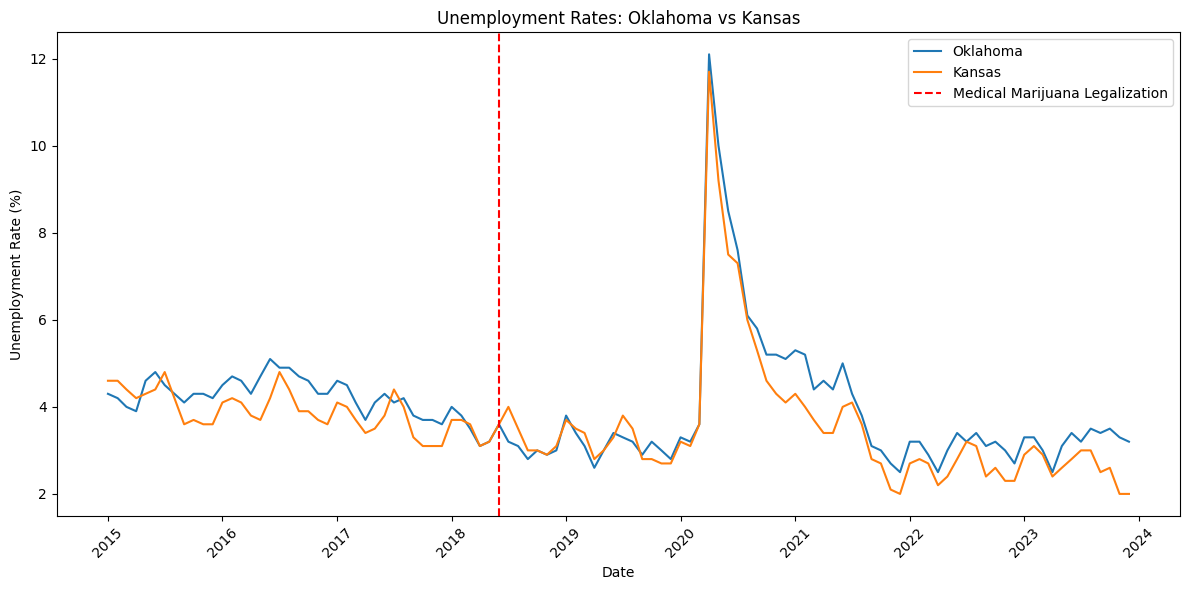

In [38]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def prepare_data(df):
    """Prepare data for analysis by handling data types and creating dummy variables"""
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Create binary indicators
    df['treatment_group'] = (df['state'] == 'Oklahoma').astype(int)
    df['post_treatment'] = (df['date'] >= '2018-06-01').astype(int)
    df['did'] = df['treatment_group'] * df['post_treatment']
    
    return df

def run_basic_did(df):
    """Run basic difference-in-differences regression"""
    # Prepare variables for regression
    y = df['unemployment_rate']
    X = sm.add_constant(df[['treatment_group', 'post_treatment', 'did']])
    
    # Run regression
    model = sm.OLS(y, X).fit(cov_type='cluster', 
                            cov_kwds={'groups': df['state']})
    return model

def run_controlled_did(df):
    """Run DiD regression with controls"""
    # Create control variables
    X = sm.add_constant(df[['treatment_group', 'post_treatment', 'did',
                           'gdp', 'personal_income', 'pct_college_degree']])
    y = df['unemployment_rate']
    
    # Run regression
    model = sm.OLS(y, X).fit(cov_type='cluster',
                            cov_kwds={'groups': df['state']})
    return model

def create_visualizations(df):
    """Create key visualizations"""
    
    # Unemployment Trends
    plt.figure(figsize=(12, 6))
    for state in ['Oklahoma', 'Kansas']:
        state_data = df[df['state'] == state]
        plt.plot(state_data['date'], state_data['unemployment_rate'],
                label=state)
    
    plt.axvline(pd.to_datetime('2018-06-01'), color='r', linestyle='--',
                label='Medical Marijuana Legalization')
    plt.title('Unemployment Rates: Oklahoma vs Kansas')
    plt.xlabel('Date')
    plt.ylabel('Unemployment Rate (%)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def calculate_summary_stats(df):
    """Calculate summary statistics for pre and post periods"""
    # Define periods
    pre_period = df['date'] < '2018-06-01'
    post_period = df['date'] >= '2018-06-01'
    
    # Calculate means for each group and period
    stats = pd.DataFrame({
        'Pre-Treatment': {
            'Oklahoma': df[pre_period & (df['state'] == 'Oklahoma')]['unemployment_rate'].mean(),
            'Kansas': df[pre_period & (df['state'] == 'Kansas')]['unemployment_rate'].mean()
        },
        'Post-Treatment': {
            'Oklahoma': df[post_period & (df['state'] == 'Oklahoma')]['unemployment_rate'].mean(),
            'Kansas': df[post_period & (df['state'] == 'Kansas')]['unemployment_rate'].mean()
        }
    })
    
    # Calculate DiD
    stats['Difference'] = stats['Post-Treatment'] - stats['Pre-Treatment']
    stats.loc['Diff-in-Diff'] = stats.loc['Oklahoma'] - stats.loc['Kansas']
    
    return stats

def check_parallel_trends(df):
    """Test parallel trends assumption"""
    # Use pre-treatment data only
    pre_data = df[df['date'] < '2018-06-01'].copy()
    
    # Create time trend
    pre_data['time'] = (pre_data['date'] - pre_data['date'].min()).dt.days
    pre_data['time_treat'] = pre_data['time'] * pre_data['treatment_group']
    
    # Run regression
    X = sm.add_constant(pre_data[['time', 'treatment_group', 'time_treat']])
    y = pre_data['unemployment_rate']
    
    model = sm.OLS(y, X).fit(cov_type='cluster',
                            cov_kwds={'groups': pre_data['state']})
    return model

def run_full_analysis(df):
    """Run complete analysis pipeline"""
    # Prepare data
    df = prepare_data(df)
    
    # Basic DiD
    print("Basic DiD Results:")
    basic_did = run_basic_did(df)
    print(basic_did.summary())
    print("\n")
    
    # Controlled DiD
    print("Controlled DiD Results:")
    controlled_did = run_controlled_did(df)
    print(controlled_did.summary())
    print("\n")
    
    # Summary Statistics
    print("Summary Statistics:")
    summary_stats = calculate_summary_stats(df)
    print(summary_stats)
    print("\n")
    
    # Parallel Trends Test
    print("Parallel Trends Test:")
    parallel_trends = check_parallel_trends(df)
    print(parallel_trends.summary())
    
    # Create visualizations
    create_visualizations(df)
    
    return {
        'basic_did': basic_did,
        'controlled_did': controlled_did,
        'summary_stats': summary_stats,
        'parallel_trends': parallel_trends
    }

# Run the analysis
processed_df = prepare_data(merged_df)
results = run_full_analysis(processed_df)